## Overlap-Add speech conversion

In [152]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile, loadmat
import librosa
from IPython.display import Audio

DATA_PATH = '/home/jorgep/OneDrive_JPais/Faculdade/Mestrado/Tese/data/'
INT16_MAX = 32767

### Odd Discrete Fourier Transform

In [153]:
def odft(x, N):
    """
    Computes the Odd Discrete Fourier Transform (ODFT) of a given signal.

    Parameters:
    x (array-like): The input signal.
    N (int): The number of samples in the DFT.

    Returns:
    array-like: The ODFT of the input signal.
    """
    f = np.arange(N) # from 0 to N-1
    dirExp = np.exp(-1j * np.pi * f / N)

    X = np.fft.fft(x*dirExp)

    #plt.plot(abs(X)) # plot the DFT magnitude

    return X

def iodft(X, N):
    """
    Performs the inverse odd discrete Fourier transform (IODFT) on the input signal.

    Parameters:
    X (array-like): The input signal in the frequency domain.
    N (int): The length of the input signal.

    Returns:
    array-like: The output signal in the time domain after applying the IODFT.
    """
    x = np.fft.ifft(X)

    f = np.arange(N) # from 0 to N-1
    x = x * np.exp(1j * np.pi * f / N)

    return x

a = np.random.normal(0, 1, 1024)
assert iodft(odft(a, 1024), 1024).all() == a.all()

### Levinson Durbin Algorithm

In [154]:
def levinson(r, N):
    """
    Apply the Levinson-Durbin recursion to compute the prediction filter coefficients.

    Parameters:
    r (array-like): Autocorrelation sequence of length N+1.
    N (int): Order of the prediction filter.

    Returns:
    tuple: A tuple containing the prediction filter coefficients (A), the prediction error (E),
           and the reflection coefficients (k).

    """
    k = np.zeros(N+1) # Reflection coefficients
    A = np.zeros(N+1) # Prediction filter coefficients
    A[0] = 1.0
    E = np.real(r[0]) # Prediction error

    # Levinson-Durbin recursion
    for i in range(1, N+1):
        lambda_ = -np.dot(r[1:i+1], A[i-1::-1]) / E
        A[1:i+1] += lambda_ * A[i-1::-1]
        E *= (1.0 - lambda_ * lambda_)
        k[i] = -lambda_
    return A, E, k[1:]

x = np.array([1.0, 0.7, 0, 0.5, 1.0, 0.5, 0.0, 0.5, 1.0])

a1 = levinson(x, 6)[0]
print("a1 (levinson):", a1)

# matlab result
result = np.array([1.000000000000000, -0.158730158730140, -0.603174603174617, -0.158730158730125, -0.587301587301598, -0.317460317460331, 0.984126984126981])
assert np.allclose(a1, result)

a1 (levinson): [ 1.         -0.15873016 -0.6031746  -0.15873016 -0.58730159 -0.31746032
  0.98412698]


### Individual Pulse Generation

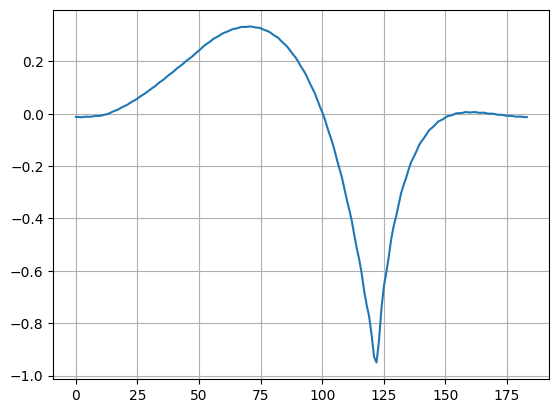

In [155]:
FS = 22050

LFmag = np.array(
[127.75712729, 125.96045048, 120.63637574, 116.86505272, 113.8789857,
 110.78919591, 108.75612537, 106.50589634, 104.56773675, 103.15588621,
 101.2940813, 100.1553461, 98.79837372, 97.49449253, 96.69426387,
  95.32664017, 94.64305041, 93.70830887, 92.72693877, 92.21235364,
  91.19303829, 90.74026643, 90.05456809, 89.24164179, 89.00770799,
  88.16411508, 87.86905499, 87.36129279, 86.73759912, 86.62027454,
  85.91529439, 85.73638821, 85.37634018, 84.8546795, 84.86114343,
  84.25057655, 84.19294799, 83.92136407, 83.50342335, 83.60809649,
  83.10197466, 83.12072764, 82.93968198, 82.62918072, 82.81524698,
  82.38319663, 82.49187896, 82.40771467, 82.15257198, 82.4169382])
tmpmag = 10 ** (LFmag/20) 

plf = [0.335465, -0.207431]
nrd_approx = np.polyval(plf, np.arange(2, len(LFmag)))
nrd_approx = np.insert(nrd_approx, 0, 0.0)
nrd_approx = np.mod(nrd_approx, 1)

def singleLFpulse(F0, Fs, mag, nrd, gain = 0.95):
    T = 1/F0 # fundamental period
    t = np.arange(0, T, 1/Fs)
    
    L = len(nrd) # number of harmonics to use (how is nrd lower than mag in this case?)
    dgf = np.zeros(len(t)) # output glottal flow derivative

    for i in range(L):
        dgf = dgf + mag[i] * np.sin((i+1)*2*np.pi*F0*t + 2*np.pi*nrd[i])

    dgf = dgf/max(abs(dgf)) * gain # normalize output signal amplitude

    return dgf

F0 = 120
pulse2 = singleLFpulse(F0, FS, tmpmag, nrd_approx)
plt.plot(pulse2)
plt.grid(True)  

### Tilt compensation

In [156]:
# Load delay coefficients and magnitudes from matlab files
mat = loadmat('LFNRD.mat')
LFnrd = mat["LFNRD"][0]
mat = loadmat('LFmag.mat')
LFmag = mat["LFmag"][0]

# NRD linear model + adjustments
# linear model of the first 20 nrd 
P = np.polyfit(np.arange(1,19), LFnrd[1:19], 1)
tmp_modelo = np.polyval(P, np.arange(1,120)) # extrapolate to 120
# shift the model to match the 20th value
shift_NRD = LFnrd[19] - tmp_modelo[19]
tmp_modelo = tmp_modelo + shift_NRD
tmp_modelo[:18] = LFnrd[:18] 

LFmag = LFmag - LFmag[0]
eixox = np.arange(1, 121)
logeixox = np.log10(eixox)

P2 = np.polyfit(logeixox[1:48], LFmag[1:48], 1)
modelo2 = np.polyval(P2, logeixox[:120])
offset = LFmag[1] - np.polyval(P2, logeixox[1])
modelo2 = modelo2 + offset
modelo2[:2] = LFmag[:2]

P1 = np.polyfit(logeixox[:2], LFmag[:2], 1)
modelo_IP = np.polyval(P1, logeixox[:2])

offset = np.polyval(P1, logeixox[1]) - np.polyval(P2, logeixox[1])
P2[1] = P2[1] + offset
modelo1 = np.polyval(P2, logeixox[1:48])

# three rules exist for compensating the magnitude curve
#      f/F0 < 1         -> G = 1
#      1 <= f/F0 < 2    -> G = m1*(f/F0) + b1
#      f/F0 >= 2        -> G = m2*(f/F0) + b2

m1_IP = P1[0]; b1_IP = P1[1]
m2_IP = P2[0]; b2_IP = P2[1]

# we can then define a function that calculates the gain
# that should be applied to the magnitude curve at a specific frequency

def tiltGain(F0, Fs, N):
    T0 = Fs/F0
    N2 = N//2

    gain = np.zeros(N2)

    for kk in range(0,N2):
        ratio = kk * (Fs/F0) / N
        if ratio < 1.0:
            gain[kk] = 1.0
        elif ratio < 2.0:
            gain[kk] = (ratio**(m1_IP/20)) * 10**(b1_IP/20)
        else:
            gain[kk] = (ratio**(m2_IP/20)) * 10**(b2_IP/20)

    return gain

### Overlap-Add Generation of glottal pulses (constant f0)

| Test Subject | Geometric Avg Fundamental Frequency (Hz) | Synthesized Frequency |
|--------------|---------------------------------------| ---- |
| SPF05 | 191.65 | 192 |
| SPF12 | 165.33 | 165 |
| SPM14 | 111.30 | 112 |
| SPM18 | 127.60 | 128 |

In [157]:
# Test subject selection from dynavoicer database

# Audio file
TEST_SUBJECT = 'SPM18' # 'SPF05' 'SPF12' 'SPM14' 'SPM18'

TEST_PHRASE = 'Aviao' # 'Tiago' 'Aviao'
F0 = 128

# Read the audio file
#IN_AUDIO_FILE = DATA_PATH + 'vowelModels/Vowel_A.wav'
#IN_AUDIO_FILE = DATA_PATH + 'levinson.wav'
IN_AUDIO_FILE = DATA_PATH + 'processed/' + TEST_SUBJECT + '_' + TEST_PHRASE + 'Whisperd.wav'
OUTPUT_FILE_1 = DATA_PATH + 'resultsEHLA/unsegmented/' + TEST_SUBJECT + '_' + TEST_PHRASE + '_1_frameFiltering.wav'
OUTPUT_FILE_2 = DATA_PATH + 'resultsEHLA/unsegmented/' + TEST_SUBJECT + '_' + TEST_PHRASE + '_2_pulseFiltering.wav'

fs, datain = wavfile.read(IN_AUDIO_FILE)
if(len(datain.shape) > 1):
    datain = datain[:, 0] # remove right channel if stereo

# trim data 
#datain = datain[int(0.15*fs):int(1.0*fs)]
datain = librosa.resample(datain.astype(np.float32), orig_sr=fs, target_sr=FS)

Audio(datain, rate=FS)

/tmp/ipykernel_76695/562789543.py:16: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, datain = wavfile.read(IN_AUDIO_FILE)


In the example below a simple way of implementing Overlap add is shown. In this case, a single filter in utilized for all pulses in the buffer. Although, individual pulse filtering is done...

In [158]:
N = 1024; N2 = N // 2

# hanning sine window for each frame
#sinW = signal.windows.hann(N)
# since we're using odft the window should be shifted
sinW = np.sin(np.pi * (np.arange(0, N) + 0.5) / N)

# input and output buffers
old_inBuff  = np.zeros(N2)
old_outBuff = np.zeros(N2)

# pulse buffers
pulseBuffer = np.zeros(N) # 1024 samples long
lastPulsePos = 0

# output file
outputFile = np.array([])
outputPulses = np.array([])

# precompute tilt factor
tilt = tiltGain(F0, FS, N)
tilt = np.concatenate((tilt, tilt[::-1]))

# load new frames 512 samples at a time
for start in range(0, len(datain) - N2, N2):
    in_frame = datain[start : start + N2]

    if(len(in_frame) != N2):
        in_frame = np.pad(in_frame, (0, N2 - len(in_frame)), 'constant')

    # Concatenate input sequence and apply window
    winFrame = np.concatenate((old_inBuff, in_frame)) * sinW
    old_inBuff = in_frame

    #print("{" + ", ".join([str(x) for x in winFrame]) + "};")

    # DFT and compute PSD
    #curr_spectrum = odft(winFrame, N)
    f = np.arange(N)
    dirExp = np.exp(-1j * np.pi * f / N)
    temp = winFrame * dirExp

    curr_spectrum = np.fft.fft(temp)
    
    curr_psd = np.abs(curr_spectrum) ** 2

    # TODO: add noise to the psd (freq. domain)

    # add tilt compensation to the model
    curr_psd = curr_psd / tilt

    # compute lpc filter from psd
    r = iodft(curr_psd, N).real # weiner-khinchin
    [a, e, k] = levinson(r[:23], 22) # the number of samples in r doesn't seem to matter
    b0 = np.sqrt(e) # gain factor calculated from the prediction error

    # pulse generation
    pulseBuffer[:N2] = pulseBuffer[N2:] # shift the buffer
    pulseBuffer[N2:] = 0 # clear the second half of the buffer 

    while lastPulsePos < N2:
        pulse = singleLFpulse(F0, FS, tmpmag, nrd_approx)
        # add white noise to the pulse
        # this is a bad way to add noise to the pulse
        # as it will overlap with the next pulse's noise
        # the best way would be to add noise to the spectrum before filtering
        #pulse += np.random.normal(0, 0.1, len(pulse)) * 0.3
        
        outputPulses = np.concatenate((outputPulses, pulse)) # save raw pulses
        lastPulseLen = len(pulse)
        pulse = np.concatenate((pulse, np.zeros(300)))

        # filter the pulse
        filteredPulse = signal.lfilter(b0, a, pulse)
        pulseBuffer[lastPulsePos : lastPulsePos + len(filteredPulse)] += filteredPulse

        lastPulsePos += lastPulseLen

    lastPulsePos -= N2

    output = pulseBuffer[:N2] # first half of the buffer

    # Add the output through overlap add and save the previous output
    outputFile = np.concatenate((outputFile, (old_outBuff * sinW[:N2] + output * sinW[N2:])))
    #outputFile = np.concatenate((outputFile, output))
    old_outBuff = output

outputFile = outputFile / max(abs(outputFile)) * INT16_MAX
#plt.plot(outputFile[int(0.1*fs):int(0.15*fs)])

# write to the output file
wavfile.write(OUTPUT_FILE_1, FS, outputFile.astype(np.int16))
Audio(OUTPUT_FILE_1, rate=FS)

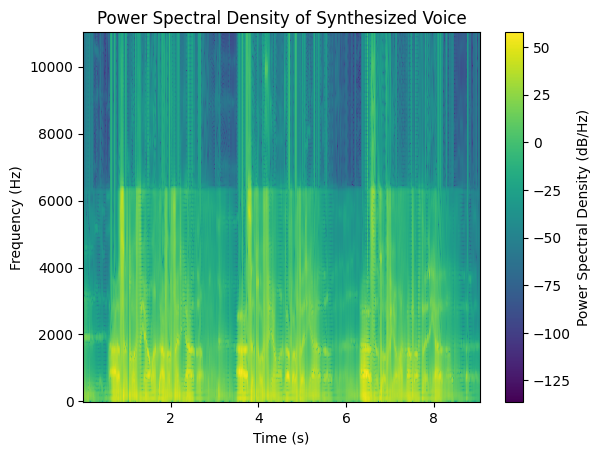

In [159]:
# Calculate the power spectral density
frequencies, times, psd = signal.spectrogram(outputFile, FS, nperseg=256, nfft=1024, noverlap=128, window='hann')

# Plot the power spectral density
plt.pcolormesh(times, frequencies, 10 * np.log10(psd))
#plt.ylim([0, 6500])
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='Power Spectral Density (dB/Hz)')
plt.title('Power Spectral Density of Synthesized Voice')
plt.show()

# Plot the original spectrogram
#frequencies, times, psd = signal.spectrogram(datain, FS, nperseg=256, nfft=1024, noverlap=128, window='hann')
#plt.pcolormesh(times, frequencies, 10 * np.log10(psd))

### Overlap-Add Generation of glottal pulses (varying f0, tilt and freq. domain white noise)

In [160]:
N = 1024; N2 = N // 2

# hanning sine window for each frame
#sinW = signal.windows.hann(N)
# since we're using odft the window should be shifted
sinW = np.sin(np.pi * (np.arange(0, N) + 0.5) / N)

# input and output buffers
old_inBuff  = np.zeros(N2)
old_outBuff = np.zeros(N2)

# pulse buffers
pulseBuffer = np.zeros(N) # 1024 samples long
# initialization for the first the pulse, such that the alpha coefficient for the PSD calculation is never 0
lastPulsePos = 1 

# power spectral density
old_psd = np.zeros(N)
pulse_psd = np.zeros(N)

# output file
outputFile = np.array([])
outputPulses = np.array([]) # TODO remove this

# tilt compensation factor
tilt = tiltGain(F0, FS, N)
tilt = np.concatenate((tilt, tilt[::-1]))

# load new frames 512 samples at a time
for start in range(0, len(datain) - N2, N2):
    in_frame = datain[start : start + N2]

    if(len(in_frame) != N2):
        in_frame = np.pad(in_frame, (0, N2 - len(in_frame)), 'constant')

    # Concatenate input sequence and apply window
    winFrame = np.concatenate((old_inBuff, in_frame)) * sinW
    old_inBuff = in_frame

    # DFT and compute PSD for current frame
    curr_spectrum = odft(winFrame, N)
    curr_psd = np.abs(curr_spectrum) ** 2

    # pulse generation
    pulseBuffer[:N2] = pulseBuffer[N2:] # shift the buffer
    pulseBuffer[N2:] = 0 # clear the second half of the buffer

    while lastPulsePos < N2:
        """ if(lastPulsePos == 0):
            lastPulsePos += 1 """
        pulse = singleLFpulse(F0, FS, tmpmag, nrd_approx)
        #pulse += np.random.normal(0, 0.1, len(pulse)) * 0.3
        
        # psd mixing coefficient, idk why the way i did it didn't work :/
        alpha = lastPulsePos / N2

        pulse_psd = (alpha)*curr_psd + (1-alpha)*old_psd # average the psds

        # TODO: add noise and tilt compensation to the psd right here
        pulse_psd = pulse_psd / tilt
        #pulse_psd = pulse_psd + 1e3 * np.ones(len(pulse_psd)) # add noise to the psd (freq. domain)

        r = iodft(pulse_psd, N).real # weiner-khinchin
        [a, e, k] = levinson(r[:23], 22)
        b0 = np.sqrt(e)

        outputPulses = np.concatenate((outputPulses, pulse)) # save raw pulses
        lastPulseLen = len(pulse)
        pulse = np.concatenate((pulse, np.zeros(300)))

        # filter the pulse
        filteredPulse = signal.lfilter(b0, a, pulse)
        pulseBuffer[lastPulsePos : lastPulsePos + len(filteredPulse)] += filteredPulse

        # update pulse position
        lastPulsePos += lastPulseLen

    lastPulsePos -= N2
    output = pulseBuffer[:N2] # first half of the buffer
    old_psd = curr_psd

    # Add the output through overlap add and save the previous output
    outputFile = np.concatenate((outputFile, (old_outBuff * sinW[:N2] + output * sinW[N2:])))
    old_outBuff = output

outputFile = outputFile / max(abs(outputFile)) * INT16_MAX

# write to the output file
wavfile.write(OUTPUT_FILE_2, FS, outputFile.astype(np.int16))
Audio(OUTPUT_FILE_2, rate=FS)

### Realtime implementation of Overlap-Add

I think the bad results are mainly due to python's poor performance. Another way to implement this could be using spotify's pedalboard API, because I do think that it can you portaudio for realtime audio processing. 

https://github.com/spotify/pedalboard

https://spotify.github.io/pedalboard/

In [161]:
""" import pyaudio

# audio parameters
FS = 22050; N = 1024; N2 = N // 2; F0 = 110
CHUNK = N2
FORMAT = pyaudio.paInt16
CHANNELS = 1

# hanning sine window
# since we're using odft the window should be shifted by half a frequency bin
sinW = np.sin(np.pi * (np.arange(0, N) + 0.5) / N)

# Create a PyAudio instance
p = pyaudio.PyAudio()

pulseBuffer = np.zeros(N) # 1024 samples long
lastPulsePos = 0

old_inBuff  = np.zeros(N2)
old_outBuff = np.zeros(N2)

tilt = tiltGain(F0, FS, N)

# Define the callback function
def callback(in_data, frame_count, time_info, status):
    global old_inBuff, old_outBuff, pulseBuffer, lastPulsePos

    in_frame = np.frombuffer(in_data, dtype=np.int16) # read from buffer

    winFrame = np.concatenate((old_inBuff, in_frame)) * sinW
    old_inBuff = in_frame

    # DFT and compute PSD
    curr_spectrum = odft(winFrame, N)
    curr_psd = np.abs(curr_spectrum) ** 2
    curr_psd = curr_psd - np.concatenate((tilt, tilt[::-1]))

    r = iodft(curr_psd, N).real # weiner-khinchin
    [a, e, k] = levinson(r[:N2], 22)

    b0 = np.sqrt(e)

    pulseBuffer[:N2] = pulseBuffer[N2:] # shift the buffer
    pulseBuffer[N2:] = 0 # clear the second half of the buffer

    while lastPulsePos < N2:
        pulse = singleLFpulse(F0, FS, tmpmag, nrd_approx)

        lastPulseLen = len(pulse)
        pulse = np.concatenate((pulse, np.zeros(300)))

        #filter the pulse
        filteredPulse = signal.lfilter(b0, a, pulse)
        pulseBuffer[lastPulsePos : lastPulsePos + len(filteredPulse)] += filteredPulse

        lastPulsePos += lastPulseLen

    lastPulsePos -= N2

    output = pulseBuffer[:N2] # first half of the buffer
    output = old_outBuff * sinW[:N2] + output * sinW[N2:] # this can't be right

    old_outBuff = output

    return (in_data, pyaudio.paContinue)
    #return (output.astype(np.int16).tobytes(), pyaudio.paContinue)

# Open the stream using the callback
stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=FS,
                input=True,
                output=True,
                frames_per_buffer=CHUNK,
                stream_callback=callback)

# Start the stream
stream.start_stream()

print("* recording")

# Main loop
try:
    while stream.is_active():
        pass
except KeyboardInterrupt:
    print("* done recording")

# Stop the stream
stream.stop_stream()
stream.close()

# Terminate the PyAudio instance
p.terminate() """

' import pyaudio\n\n# audio parameters\nFS = 22050; N = 1024; N2 = N // 2; F0 = 110\nCHUNK = N2\nFORMAT = pyaudio.paInt16\nCHANNELS = 1\n\n# hanning sine window\n# since we\'re using odft the window should be shifted by half a frequency bin\nsinW = np.sin(np.pi * (np.arange(0, N) + 0.5) / N)\n\n# Create a PyAudio instance\np = pyaudio.PyAudio()\n\npulseBuffer = np.zeros(N) # 1024 samples long\nlastPulsePos = 0\n\nold_inBuff  = np.zeros(N2)\nold_outBuff = np.zeros(N2)\n\ntilt = tiltGain(F0, FS, N)\n\n# Define the callback function\ndef callback(in_data, frame_count, time_info, status):\n    global old_inBuff, old_outBuff, pulseBuffer, lastPulsePos\n\n    in_frame = np.frombuffer(in_data, dtype=np.int16) # read from buffer\n\n    winFrame = np.concatenate((old_inBuff, in_frame)) * sinW\n    old_inBuff = in_frame\n\n    # DFT and compute PSD\n    curr_spectrum = odft(winFrame, N)\n    curr_psd = np.abs(curr_spectrum) ** 2\n    curr_psd = curr_psd - np.concatenate((tilt, tilt[::-1]))\n\n  